In [14]:
import os,glob,zipfile
from Code import HBV_pso
from Code import nam_pso
from Code import GR4J_pso
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display,  clear_output
from ipywidgets import FileUpload


/home/cak/Desktop/jupyter/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Model Selection 

In [2]:
files = glob.glob1('./Data','*.csv')

file = widgets.Dropdown(
    options=files,
    description='Data:',
    disabled=False,
)

w = widgets.Dropdown(
    options=['NAM', 'HBV', 'GR4J'],
    value='HBV',
    description='Model:',
    disabled=False,
)


area = widgets.BoundedFloatText(
    value=100,
    min=0,
    max=5000.0,
    step=0.1,
    description='Area:',
    disabled=False
)

cal = widgets.RadioButtons(
    options=['True','False'],
    value='False',
    description='Calibration <br>: ',
    disabled=False
)

m = widgets.Dropdown(
    options=['SLSQP', 'PSO', 'BFGS','Newton-CG'],
    value='SLSQP',
    description='Method:',
    disabled=False,
)

max_ = widgets.IntText(
    value=7,
    description='Max Iteration:',
    disabled=False
)


spin = widgets.IntText(
    value=7,
    description='Spinoff Day:',
    disabled=False
)


obj = widgets.Dropdown(
    options=['NSE', 'KGE', 'RMSE','R2','RMPW','NSLF'],
    value='NSE',
    description='Objective',
    disabled=False,
)



display(file,w,area,cal,m,spin,max_,obj)

Dropdown(description='Data:', options=('L0123002_2005_2012.csv', 'L0123001_2005_2012.csv', 'Darbogaz.csv', 'L0…

Dropdown(description='Model:', index=1, options=('NAM', 'HBV', 'GR4J'), value='HBV')

BoundedFloatText(value=100.0, description='Area:', max=5000.0, step=0.1)

RadioButtons(description='Calibration <br>: ', index=1, options=('True', 'False'), value='False')

Dropdown(description='Method:', options=('SLSQP', 'PSO', 'BFGS', 'Newton-CG'), value='SLSQP')

IntText(value=7, description='Spinoff Day:')

IntText(value=7, description='Max Iteration:')

Dropdown(description='Objective', options=('NSE', 'KGE', 'RMSE', 'R2', 'RMPW', 'NSLF'), value='NSE')

In [3]:
if w.value == 'HBV':
    params = [1.06653896e+00, 7.85803777e-01, 1.12456396e+00, 4.00000005e-02
        , 6.52779758e+01, 1.40000000e+00, 2.04563613e-01, 5.00000000e-01
        , 7.23806920e-03, 6.20000000e-04, 5.98308241e-01, 2.29012429e+00
        , 2.32816764e-02, 4.01249854e-01, 0.00000000e+00, 1.25000000e-01
        , 1.19040117e+00, 1.40000000e+00, 6.15462361e+00]
    States = np.array([0, 0, 0.9 * params[1], 0, 0, 0, 0, 0.1])
elif w.value == 'NAM':
        params = [6.96780205e+00, 4.86098809e+02, 6.66247792e-01, 5.42601108e+02
        , 2.43815545e+01, 8.21285865e-01, 1.00000000e-02, 1.00000000e-02
        , 7.37979357e+02, 9.64180895e-01, 2.06295770e+00]
        States = np.array([0, 0, 0.9 * params[1], 0, 0, 0, 0, 0.1])
else:
        params = np.array([350, 0.5, 90, 0.5, 0.5, 4])

In [4]:
print(w.value,file.value,area.value,cal.value,m.value,spin.value,max_.value,obj.value)

HBV L0123002_2005_2012.csv 100.0 False SLSQP 7 7 NSE


In [5]:
button = widgets.Button(description="Run")
output = widgets.Output()


def process(b):
    
    if w.value == 'HBV':
            n = HBV_pso.Hbv(area.value, params, States, calibration=eval(cal.value), method=m.value, Objective_fun=obj.value.lower(), maxiter=max_.value,Spinoff=spin.value)
    elif w.value == 'NAM':
        n = nam_pso.Nam(area.value, params,States, calibration=eval(cal.value), method=m.value, Objective_fun=obj.value.lower(),maxiter=max_.value)
    else:
        n = GR4J_pso.GR4J(area.value, params, params, calibration=eval(cal.value), method=m.value, Objective_fun=obj.value.lower(), maxiter=max_.value, Spinoff=spin.value)
    n.process_path = './Data'
    n.Data_file = os.path.join(n.process_path, file.value)
    n.run()
    n.update()
    n.draw()
    # clear_o
    process.data = n.df
    return process.data
    
button.on_click(process)
display(button)


Button(description='Run', style=ButtonStyle())

In [6]:
from bokeh.plotting import figure, ColumnDataSource, output_file, save
from bokeh.models import Span, CrosshairTool, HoverTool, ResetTool, PanTool, WheelZoomTool, BoxZoomTool,SaveTool,FixedTicker,DaysTicker, FuncTickFormatter
from bokeh.io import output_notebook, show
from bokeh.models import DataRange1d,DatetimeTickFormatter
from bokeh.palettes import Dark2_5 as palette
import itertools
import datetime
colors = itertools.cycle(palette) 

output_notebook()

TOOLS = [PanTool(),WheelZoomTool(),ResetTool(),BoxZoomTool(),SaveTool()]

hover = HoverTool(
    tooltips=[
        ( 'Date',   '@Date{%F}'          ),
        ( 'Q',  '@Q' ), # use @{ } for field names with spaces
        ( 'Qsim', '@Qsim'      ),
    ],

    formatters={
        'Date'      : 'datetime', # use 'datetime' formatter for 'date' field
        'adj close' : 'printf',   # use 'printf' formatter for 'adj close' field
                                  # use default 'numeral' formatter for other fields
    },

    mode='vline'
) 
p = figure(title = 'Simulation' ,x_axis_label = 'Date', y_axis_label = 'Q',x_axis_type="datetime",plot_width=900, plot_height=600,tools=TOOLS)
source = ColumnDataSource(process.data[spin.value:] )
p.line(x='Date', y='Q',source=source,line_color="red",line_dash="4 4", line_width=2,legend_label='Simulated',alpha = 0.8)
p.line(x='Date', y='Qsim',source=source,line_color="blue", line_width=2,legend_label='Observed',alpha = 0.8)

# p.line(x='date', y='mean',source=source,line_color='#3288bd', line_width=2,legend_label=str(x))
# p.x_range = DataRange1d(start=datetime.datetime(int(2016), 10, 1, 0, 0, 0), end=datetime.datetime(int(2017), 10, 1, 0, 0, 0))
p.add_tools(hover)
show(p)

Loading BokehJS ...

AttributeError: 'function' object has no attribute 'data'

In [37]:
from ipyleaflet import *
import glob,json,os
import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import geopandas as gpd
from random import randint

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

files = glob.glob('./uploaded_data/*')
for f in files:
    os.remove(f)
    
center = [37.6252978589571, 37.34580993652344]
zoom = 5

dc = DrawControl(marker={'shapeOptions': {'color': '#0000FF'}},
                 rectangle={'shapeOptions': {'color': '#0000FF'}},
                 circle={'shapeOptions': {'color': '#0000FF'}},
                 circlemarker={},
                 )
base = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2017-01-01")

m = Map(center=center, zoom=zoom)
m.add_layer(base)
m.add_control(LayersControl())
m.add_control(dc)

m

Map(center=[37.6252978589571, 37.34580993652344], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [47]:
from shapely.geometry.polygon import Polygon
from shapely import wkb

try:
    poly_union = gpd.GeoDataFrame()
    my_poly=dc.last_draw['geometry']['coordinates'][0]
    geom = Polygon(my_poly)
    poli= gpd.GeoDataFrame(geometry=[geom])
    poli['ID'] = 'TR'
    poli.to_file("../file_uploads/drawed.shp")
    print("Shape file created")
    my_poly
except:
    print("Shape file could not created, draw a polygon in map")

Shape file created


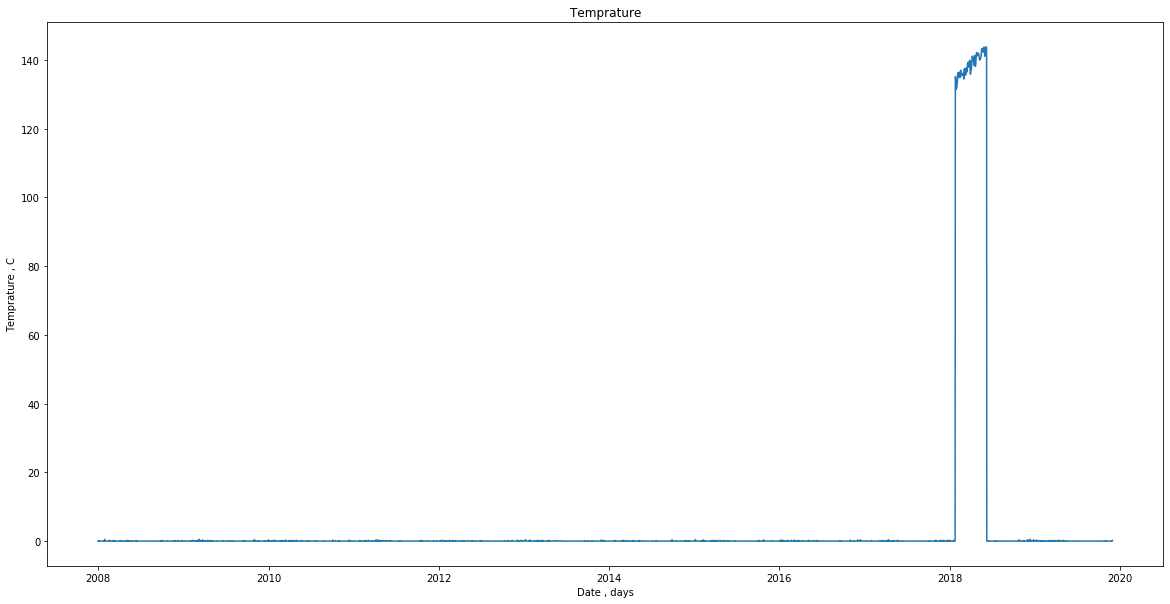

In [49]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from query import query
connection = psycopg2.connect(user = "postgres",
                              password = passwd,
                              host = server,
                              port = "5999",
                              database = "postgres")

cursor = connection.cursor()


cursor.execute('CREATE TEMP TABLE my_lines(geom geometry, name text)')
cursor.execute(
    'INSERT INTO my_lines(geom, name)'
    'VALUES (ST_SetSRID(%(geom)s::geometry, %(srid)s), %(name)s)',
    {'geom': geom.wkb_hex, 'srid': 4326, 'name': 'First Line'})
connection.commit()

cursor.execute('SELECT geom FROM my_lines')
cursor.execute('SELECT name, geom FROM my_lines')
for name, geom_wkb in cursor:
    geom = wkb.loads(geom_wkb, hex=True)
    polygon = geom.wkt

sql = query('Temp',geom)
sql = query('pre',geom)
# sql = query('pot',geom)
# sql = query('snow',geom)

cursor.execute(sql)
data = cursor.fetchall() 
df = pd.DataFrame(data)
plt.figure(figsize=(20,10))
plt.plot(df[0],df[1])
plt.title('Temprature')
plt.xlabel('Date , days')
plt.ylabel('Temprature , C')
plt.show()
cursor.close()
connection.close()
